<a href="https://colab.research.google.com/github/Angelvj/Alzheimer-disease-classification/blob/main/code/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, os
import tensorflow as tf
import nibabel as nib
from google.colab import drive
import matplotlib.pyplot as plt
import scipy 

In [2]:
DEVICE = 'TPU'

if DEVICE == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        STRATEGY = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        print('Could not connect to TPU, setting default strategy')
        tpu = None
        STRATEGY = tf.distribute.get_strategy()
elif DEVICE == 'GPU':
    tpu = None
    STRATEGY = tf.distribute.MirroredStrategy()
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = STRATEGY.num_replicas_in_sync

print(f'Number of accelerators: {REPLICAS}')

Could not connect to TPU, setting default strategy
Number of accelerators: 1


In [3]:
# Image visualization
def show_mid_slice(img_numpy, title='img'):
    """
    Accepts an 3D numpy array and shows median slices in all three planes
    """
    assert img_numpy.ndim == 3
    n_i, n_j, n_k = img_numpy.shape

    # sagittal (left image)
    center_i1 = int((n_i - 1) / 2)
    # coronal (center image)
    center_j1 = int((n_j - 1) / 2)
    # axial slice (right image)
    center_k1 = int((n_k - 1) / 2)

    show_slices([img_numpy[center_i1, :, :],
                img_numpy[:, center_j1, :],
                img_numpy[:, :, center_k1]])
    plt.suptitle(title)

def show_slices(slices):
   """
   Function to display a row of image slices
   Input is a list of numpy 2D image slices
   """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [13]:
# Data augmentation

def augment_image(img):

    # img = img.reshape((img.shape[:-1]))
    img = img.squeeze()
    # img = random_rotations(img, -5, 5)
    # img = random_zoom(img)
    # img = random_flip(img)
    img = random_shift(img)

    img = np.expand_dims(img, axis=3) # Restore channel axis
    return img

@tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
def tf_augment_image(input):
    """ Tensorflow can't manage numpy functions, we have to wrap our augmentation function """
    img = tf.numpy_function(augment_image, [input], tf.float32)
    return img

def random_rotations(img, min_angle, max_angle):
    """
    Rotate 3D image randomly
    """
    assert img.ndim == 3, "Image must be 3D"
    rotation_axes = [(1, 0), (1, 2), (0, 2)]
    angle = np.random.randint(low=min_angle, high=max_angle+1)
    axes_random_id = np.random.randint(low=0, high=len(rotation_axes))
    axis = rotation_axes[axes_random_id] # Select a random rotation axis
    return scipy.ndimage.rotate(img, angle, axes=axis)

def random_zoom(img,min=0.7, max=1.2):
    """
    Generate random zoom of a 3D image
    """
    zoom = np.random.sample()*(max - min) + min # Generate random zoom between min and max
    zoom_matrix = np.array([[zoom, 0, 0, 0],
                            [0, zoom, 0, 0],
                            [0, 0, zoom, 0],
                            [0, 0, 0, 1]])
    
    return scipy.ndimage.interpolation.affine_transform(img, zoom_matrix)

def random_flip(img):
    """
    Flip image over a random axis
    """
    axes = [0, 1, 2]
    rand_axis = np.random.randint(len(axes))
    img = img.swapaxes(rand_axis, 0)
    img = img[::-1, ...]
    img = img.swapaxes(0, rand_axis)
    img = np.squeeze(img)
    return img

def random_shift(img, max=0.4):
    """
    Random shift over a random axis
    """
    (x, y, z) = img.shape
    (max_shift_x, max_shift_y, max_shift_z) = int(x*max/2),int(y*max/2), int(z*max/2)
    shift_x = np.random.randint(-max_shift_x, max_shift_x)
    shift_y = np.random.randint(-max_shift_y,max_shift_y)
    shift_z = np.random.randint(-max_shift_z,max_shift_z)

    translation_matrix = np.array([[1, 0, 0, shift_x],
                                   [0, 1, 0, shift_y],
                                   [0, 0, 1, shift_z],
                                   [0, 0, 0, 1]
                                   ])

    return scipy.ndimage.interpolation.affine_transform(img, translation_matrix)

In [6]:
NUM_CLASSES = 3
IMG_SHAPE = (79, 95, 68, 1)

def load_image(path):    

    img = nib.load(path)
    img = np.asarray(img.dataobj, dtype=np.float32)
    img = np.expand_dims(img, axis=3) # Add dummy axis for channel
    return img

def max_intensity_normalization(X, proportion):

    n_max_values = int(np.prod(X.shape, axis=0) * proportion)
    n_max_idx = np.unravel_index((X).argsort(axis=None)[-n_max_values:], X.shape)
    mean = np.mean(X[n_max_idx])
    X /= mean

def preprocess_image(X, steps, arguments):

    for f, args in zip(steps, arguments):
        f(X, *arguments)


def read_tfrecord(example):
    tfrec_format = {
        "image": tf.io.VarLenFeature(tf.float32),
        "one_hot_label": tf.io.VarLenFeature(tf.float32)
        # "filename": tf.io.FixedLenFeature([], tf.string) 
    }

    example = tf.io.parse_single_example(example, tfrec_format)
    one_hot_label = tf.sparse.to_dense(example['one_hot_label'])
    one_hot_label = tf.reshape(one_hot_label, [NUM_CLASSES])
    image = tf.reshape(tf.sparse.to_dense(example['image']), IMG_SHAPE)
    # filename = example['filename']
    
    # TPU needs size to be known, so this doesn't work
    #     image  = tf.reshape(example['image'], example['shape']) 
    return image, one_hot_label

def load_dataset(filenames):
    
    # Allow order-altering optimizations
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTO)
    return dataset

def get_dataset(filenames, batch_size = 8, augment=True):
    dataset =  load_dataset(filenames)

    # dataset = dataset.chache()
    # dataset = dataset.repeat()

    if augment:
        dataset = dataset.map(lambda img, one_hot: (
                                tf_augment_image(img), one_hot), 
                                num_parallel_calls=AUTO
                            )

    dataset = dataset.batch(batch_size * REPLICAS)
    dataset = dataset.prefetch(AUTO)
    return dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


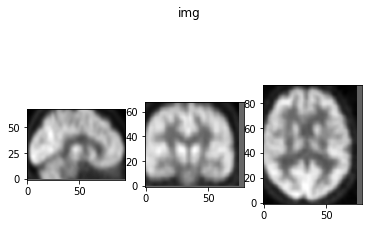

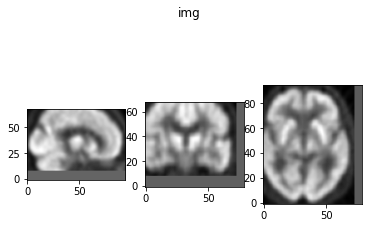

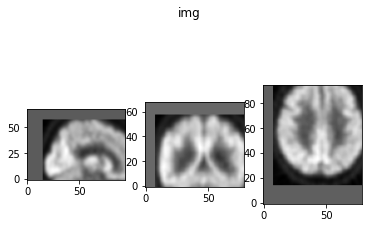

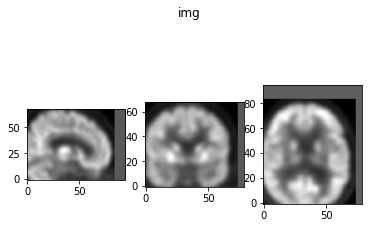

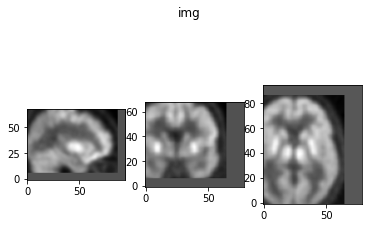

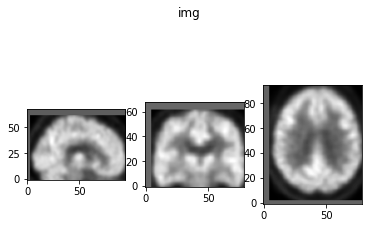

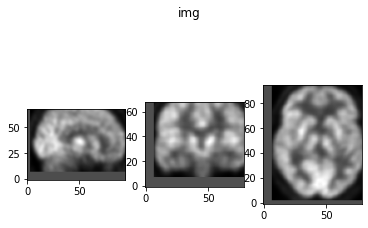

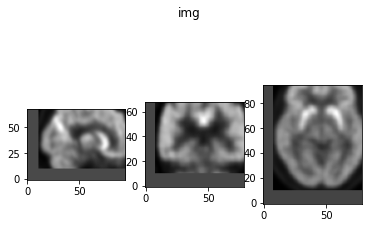

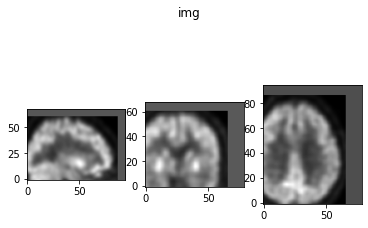

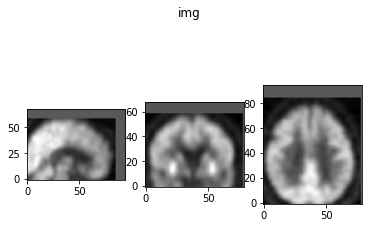

In [16]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/data/'

DS_PATH = DATA_PATH + 'tfrec-pet-spatialnorm-elastic-standarized' # or GCS path

get_filenames = lambda pattern : tf.io.gfile.glob(pattern)

pet_train = get_dataset(get_filenames(DS_PATH + '/train/*.tfrec'), batch_size=1)
pet_test = get_dataset(get_filenames(DS_PATH + '/test/*.tfrec'), batch_size=1)

for i, data in enumerate(pet_train):

    if i ==10:
        break
    image = data[0].numpy()[0]
    label = data[1].numpy()[0].astype(int)
    image = image.reshape((image.shape[:-1]))

    show_mid_slice(image)